# Detection of Bird Species using modern CNN Algorithms

Colab Setup

---

\



In [1]:
!nvidia-smi

Tue Nov 17 12:56:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Data Source : https://www.kaggle.com/gpiosenka/100-bird-species
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"quicksilvershanks","key":"7a011dee462351bef7729a0bed800a95"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-bccr2dcs
  Running command git clone -q https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-bccr2dcs
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=78792 sha256=cae015cc572ee64e0b2a75d588bb12613cb66d81b830758809997713f6056fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1qv3erqr/wheels/2f/2c/1d/18a38a6b617c2c338bdcbf409f3ccc2452799db7dca965d475
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species
# !cp -v /content/100-bird-species.zip '/content/gdrive/My Drive/d2l_study group files/'
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/SUPERB STARLING/068.jpg  
  inflating: train/SUPERB STARLING/069.jpg  
  inflating: train/SUPERB STARLING/070.jpg  
  inflating: train/SUPERB STARLING/071.jpg  
  inflating: train/SUPERB STARLING/072.jpg  
  inflating: train/SUPERB STARLING/073.jpg  
  inflating: train/SUPERB STARLING/074.jpg  
  inflating: train/SUPERB STARLING/075.jpg  
  inflating: train/SUPERB STARLING/076.jpg  
  inflating: train/SUPERB STARLING/077.jpg  
  inflating: train/SUPERB STARLING/078.jpg  
  inflating: train/SUPERB STARLING/079.jpg  
  inflating: train/SUPERB STARLING/080.jpg  
  inflating: train/SUPERB STARLING/081.jpg  
  inflating: train/SUPERB STARLING/082.jpg  
  inflating: train/SUPERB STARLING/083.jpg  
  inflating: train/SUPERB STARLING/084.jpg  
  inflating: train/SUPERB STARLING/085.jpg  
  inflating: train/SUPERB STARLING/086.jpg  
  inflating: train/SUPERB STARLING/087.jpg  
  inflating: train/SUPERB STARLING/088.jpg  
  in

Importing Necessary Libraries

---



In [5]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

In [7]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [8]:
!pip install -U d2l
from d2l import torch as d2l

     |████████████████████████████████| 61kB 3.5MB/s 


Exploratory Analysis

---



In [9]:
DATA_DIR = '/content'

TRAIN_DIR = DATA_DIR + '/train'     # Contains training images
TEST_DIR = DATA_DIR + '/test'       # Contains test images
VALID_DIR = DATA_DIR + '/valid'     # Contains training images

In [ ]:
print("Total Number of Bird Species :", len(os.listdir(TRAIN_DIR)))

Total Number of Bird Species : 225


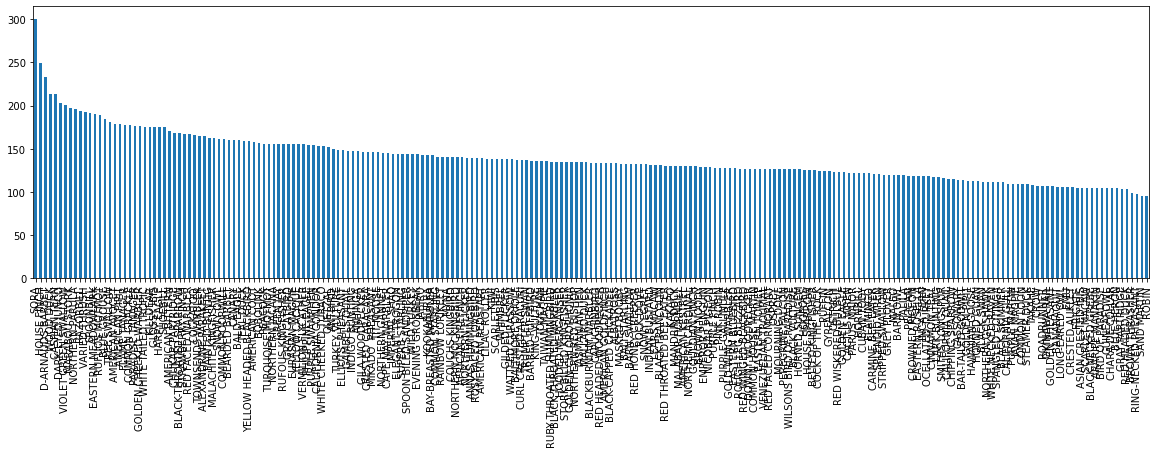

In [ ]:
# Exploring any possible Class Imbalance
def bird_freq(path):
    bird_cnt={}
    for species in os.listdir(path):
        bird_cnt[species] = len(os.listdir(path + "/" + species))
    return bird_cnt

bird_cnt = pd.Series(bird_freq(TRAIN_DIR)).sort_values(ascending=False)

plt.figure(figsize=(20,5))
bird_cnt.plot.bar()

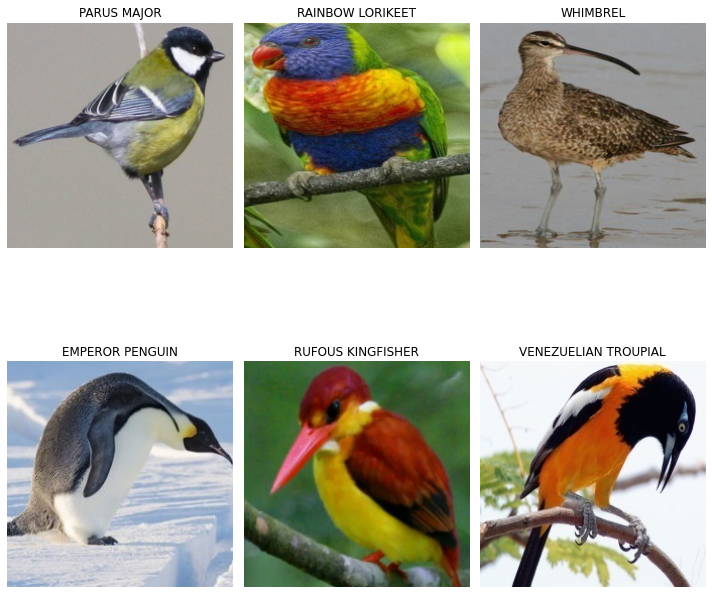

In [ ]:
# Display an image grid with random images
def grid_random(nrow=2, ncol=2):
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(5*nrow,5*ncol))
    for i in range(nrow):
        for j in range(ncol):
            r_species = random.choice(os.listdir(TRAIN_DIR))
            r_bird = random.choice(os.listdir(TRAIN_DIR + '/' + r_species))
            bird = imread(TRAIN_DIR + '/' + r_species + '/' + r_bird)
            axes[i,j].imshow(bird)
            axes[i,j].set_title(r_species)
            axes[i,j].axis('off')
            fig.tight_layout()
grid_random(2,3)

Import Data into a DataLoader

---





In [10]:
# Image transformations for resizing input images and augmentation at a later stage
transformations = transforms.Compose([
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # used for GoogLeNet and ResNet
                                      transforms.RandomHorizontalFlip(p=0.5)
])
transform_test = transforms.Compose([
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # used for GoogLeNet and ResNet
])

In [11]:
train_set = datasets.ImageFolder(TRAIN_DIR, transform = transformations)
valid_set = datasets.ImageFolder(VALID_DIR, transform = transform_test)
test_set = datasets.ImageFolder(TEST_DIR, transform = transform_test)

In [12]:
batch_size = 256 # Change batch size ensure faster training (AlexNet-128, VGG16-64, GoogLeNet-256, GoogLeNet_bn-256)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle=True)

Training a PyTorch based AlexNet Classification Model


---



In [ ]:
# Source : https://d2l.ai/chapter_convolutional-modern/alexnet.html
model_alexnet = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 225))

In [ ]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_alexnet.to(device)

Device in Use : cuda


Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten()
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_features=4096, out_features=

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 25, 0.01, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_alexnet.parameters(), lr=lr, momentum=momentum)

In [13]:
# Function to get Accuracy in Validation Data
# Source : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
def val_acc(net, valloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [14]:
# Model Training Function
# Source : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
def train(net, num_epoch, device, optimizer, criterion, trainloader, valloader):
    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, start=0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Training and Validation Accuracy Calculation
        t_acc = val_acc(net, trainloader)
        v_acc = val_acc(net, valloader)
        
        # print statistics after end of every epoch
        print('[Epoch %2d/%2d] Training Loss: %.3f :: Training Accuracy : %d %% :: Validation Accuracy : %d %%' % (epoch + 1, num_epoch, running_loss / (i+1), t_acc, v_acc))
        running_loss = 0.0

    print('Finished Training')

In [ ]:
# Model Train Loop
train(net=model_alexnet, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/25] Training Loss: 5.414 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  2/25] Training Loss: 5.407 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  3/25] Training Loss: 5.401 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  4/25] Training Loss: 5.388 :: Training Accuracy : 1 % :: Validation Accuracy : 0 %
[Epoch  5/25] Training Loss: 5.304 :: Training Accuracy : 1 % :: Validation Accuracy : 1 %
[Epoch  6/25] Training Loss: 5.006 :: Training Accuracy : 3 % :: Validation Accuracy : 2 %
[Epoch  7/25] Training Loss: 4.740 :: Training Accuracy : 5 % :: Validation Accuracy : 5 %
[Epoch  8/25] Training Loss: 4.381 :: Training Accuracy : 10 % :: Validation Accuracy : 12 %
[Epoch  9/25] Training Loss: 3.988 :: Training Accuracy : 16 % :: Validation Accuracy : 18 %
[Epoch 10/25] Training Loss: 3.554 :: Training Accuracy : 23 % :: Validation Accuracy : 26 %
[Epoch 11/25] Training Loss: 3.091 :: Training Accuracy : 35 % :: Validation Accurac

In [ ]:
# Test Data Accuracy
print('Accuracy of AlexNet on Test Images: %d %%' % (val_acc(net=model_alexnet, valloader=test_loader)))

Accuracy of AlexNet on Test Images: 80 %


In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_alexnet.pth'
torch.save(model_alexnet.state_dict(), PATH)

Training a PyTorch based VGG-16 Classification Model

---




In [ ]:
# Convolution Block used in VGG architectures
# Source : https://d2l.ai/chapter_convolutional-modern/vgg.html
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
# Constructing VGG-16 Architecture using vgg blocks
# Source : https://d2l.ai/chapter_convolutional-modern/vgg.html
def vgg(conv_arch):
    # The convolutional part
    conv_blks = []
    in_channels = 3
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 225))

conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)) # VGG-16 : 8conv blocks + 3 fully connected layers
model_vgg16 = vgg(conv_arch)

In [ ]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_vgg16.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
   

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 10, 1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=lr, momentum=momentum)

In [ ]:
# Model Train Loop
train(net=model_vgg16, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/10] Training Loss: 5.440 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  2/10] Training Loss: 5.438 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  3/10] Training Loss: 5.439 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  4/10] Training Loss: 5.440 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  5/10] Training Loss: 5.441 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %


KeyboardInterrupt: ignored

In [ ]:
# Test Data Accuracy
print('Accuracy of vgg-11 on Test Images: %d %%' % (val_acc(net=model_vgg11, valloader=test_loader)))

In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_vgg11.pth'
torch.save(model_vgg11.state_dict(), PATH)

Training a PyTorch based GoogLeNet Classification Model (without BatchNormalization)

---



In [ ]:
# Inception Blocks used in GoogLeNet
# Source : https://d2l.ai/chapter_convolutional-modern/googlenet.html
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# GoogLeNet Model Architecture
# Source : https://d2l.ai/chapter_convolutional-modern/googlenet.html
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())

model_googlenet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 225))

In [ ]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_googlenet.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, kernel_size=(1, 1),

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 10, 0.1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_googlenet.parameters(), lr=lr, momentum=momentum)

In [ ]:
# Model Train Loop
train(net=model_googlenet, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/10] Training Loss: 5.409 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  2/10] Training Loss: 5.402 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  3/10] Training Loss: 5.401 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  4/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  5/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  6/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  7/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  8/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch  9/10] Training Loss: 5.399 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
[Epoch 10/10] Training Loss: 5.400 :: Training Accuracy : 0 % :: Validation Accuracy : 0 %
Finished Training


In [ ]:
# Test Data Accuracy
print('Accuracy of GoogLeNet on Test Images: %d %%' % (val_acc(net=model_googlenet, valloader=test_loader)))

Accuracy of GoogLeNet on Test Images: 0 %


In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_googlenet.pth'
torch.save(model_googlenet.state_dict(), PATH)

Training a PyTorch based GoogLeNet Classification Model (with BatchNormalization)

---

In [ ]:
# Inception Blocks used in GoogLeNet
# Source : https://d2l.ai/chapter_convolutional-modern/googlenet.html
class Inception_bn(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception_bn, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p1_1bn = nn.BatchNorm2d(c1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p2_1bn = nn.BatchNorm2d(c2[0])
        self.p2_2bn = nn.BatchNorm2d(c2[1])
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p3_1bn = nn.BatchNorm2d(c3[0])
        self.p3_2bn = nn.BatchNorm2d(c3[1])
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        self.p4_2bn = nn.BatchNorm2d(c4)

    def forward(self, x):
        p1 = F.relu(self.p1_1bn(self.p1_1(x)))
        p2 = F.relu(self.p2_2bn(self.p2_2(F.relu(self.p2_1bn(self.p2_1(x))))))
        p3 = F.relu(self.p3_2bn(self.p3_2(F.relu(self.p3_1bn(self.p3_1(x))))))
        p4 = F.relu(self.p4_2bn(self.p4_2(self.p4_1(x))))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# GoogLeNet Model Architecture
# Source : https://d2l.ai/chapter_convolutional-modern/googlenet.html
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),nn.BatchNorm2d(192),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception_bn(192, 64, (96, 128), (16, 32), 32),
                   Inception_bn(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception_bn(480, 192, (96, 208), (16, 48), 64),
                   Inception_bn(512, 160, (112, 224), (24, 64), 64),
                   Inception_bn(512, 128, (128, 256), (24, 64), 64),
                   Inception_bn(512, 112, (144, 288), (32, 64), 64),
                   Inception_bn(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception_bn(832, 256, (160, 320), (32, 128), 128),
                   Inception_bn(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())

model_googlenet_bn = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 225))

In [ ]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_googlenet_bn.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception_bn(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p1_1bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 10, 0.1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_googlenet_bn.parameters(), lr=lr, momentum=momentum)

In [ ]:
# Model Train Loop
train(net=model_googlenet_bn, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/10] Training Loss: 6.697 :: Training Accuracy : 1 % :: Validation Accuracy : 0 %
[Epoch  2/10] Training Loss: 5.240 :: Training Accuracy : 1 % :: Validation Accuracy : 0 %
[Epoch  3/10] Training Loss: 5.125 :: Training Accuracy : 3 % :: Validation Accuracy : 2 %
[Epoch  4/10] Training Loss: 4.845 :: Training Accuracy : 5 % :: Validation Accuracy : 5 %
[Epoch  5/10] Training Loss: 4.361 :: Training Accuracy : 12 % :: Validation Accuracy : 12 %
[Epoch  6/10] Training Loss: 3.615 :: Training Accuracy : 26 % :: Validation Accuracy : 28 %
[Epoch  7/10] Training Loss: 2.865 :: Training Accuracy : 42 % :: Validation Accuracy : 46 %
[Epoch  8/10] Training Loss: 2.310 :: Training Accuracy : 50 % :: Validation Accuracy : 54 %
[Epoch  9/10] Training Loss: 1.918 :: Training Accuracy : 58 % :: Validation Accuracy : 63 %
[Epoch 10/10] Training Loss: 1.623 :: Training Accuracy : 65 % :: Validation Accuracy : 69 %
Finished Training


In [ ]:
# Test Data Accuracy
print('Accuracy of GoogLeNet(with batchnorm) on Test Images: %d %%' % (val_acc(net=model_googlenet_bn, valloader=test_loader)))

Accuracy of GoogLeNet(with batchnorm) on Test Images: 71 %


In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_googlenet_bn.pth'
torch.save(model_googlenet_bn.state_dict(), PATH)

<U>Note</U> : *The rest of the training for GoogLeNet was done on another session so we now load the saved model and continue training*

In [ ]:
# Load the saved model to continue training. It would have been better to save optimiser state as well.
# Source : https://pytorch.org/tutorials/beginner/saving_loading_models.html
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
PATH = '/content/gdrive/My Drive/d2l_study group files/model_googlenet_bn.pth'
model_googlenet_bn.load_state_dict(torch.load(PATH))
model_googlenet_bn.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception_bn(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p1_1bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 15, 0.1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_googlenet_bn.parameters(), lr=lr, momentum=momentum)

In [ ]:
# Model Train Loop (was trained for 15 epochs earlier, now we train it for 15 more)
train(net=model_googlenet_bn, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/15] Training Loss: 1.384 :: Training Accuracy : 69 % :: Validation Accuracy : 74 %
[Epoch  2/15] Training Loss: 1.222 :: Training Accuracy : 72 % :: Validation Accuracy : 76 %
[Epoch  3/15] Training Loss: 1.082 :: Training Accuracy : 75 % :: Validation Accuracy : 78 %
[Epoch  4/15] Training Loss: 0.951 :: Training Accuracy : 77 % :: Validation Accuracy : 80 %
[Epoch  5/15] Training Loss: 0.846 :: Training Accuracy : 80 % :: Validation Accuracy : 81 %
[Epoch  6/15] Training Loss: 0.773 :: Training Accuracy : 82 % :: Validation Accuracy : 82 %
[Epoch  7/15] Training Loss: 0.679 :: Training Accuracy : 83 % :: Validation Accuracy : 84 %
[Epoch  8/15] Training Loss: 0.602 :: Training Accuracy : 84 % :: Validation Accuracy : 83 %
[Epoch  9/15] Training Loss: 0.555 :: Training Accuracy : 87 % :: Validation Accuracy : 85 %
[Epoch 10/15] Training Loss: 0.475 :: Training Accuracy : 89 % :: Validation Accuracy : 86 %
[Epoch 11/15] Training Loss: 0.440 :: Training Accuracy : 90 % :: Vali

In [ ]:
# Test Data Accuracy
print('Accuracy of GoogLeNet(with batchnorm) on Test Images: %d %%' % (val_acc(net=model_googlenet_bn, valloader=test_loader)))

Accuracy of GoogLeNet(with batchnorm) on Test Images: 88 %


In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_googlenet_bn_v2.pth'
torch.save(model_googlenet_bn.state_dict(), PATH)

Training a PyTorch based ResNet-18 Classification Model

---

In [ ]:
# Residual Blocks used in ResNet
# Source : https://d2l.ai/chapter_convolutional-modern/resnet.html#resnet-model
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
# ResNet-18 Modules
# Source : https://d2l.ai/chapter_convolutional-modern/resnet.html#resnet-model

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# ResNet-18 Model Architecture

b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

model_resnet18 = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 225))

In [ ]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_resnet18.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 10, 0.1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=lr, momentum=momentum)

In [ ]:
# Model Train Loop
train(net=model_resnet18, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/10] Training Loss: 4.458 :: Training Accuracy : 17 % :: Validation Accuracy : 17 %
[Epoch  2/10] Training Loss: 2.921 :: Training Accuracy : 46 % :: Validation Accuracy : 49 %
[Epoch  3/10] Training Loss: 1.919 :: Training Accuracy : 60 % :: Validation Accuracy : 65 %
[Epoch  4/10] Training Loss: 1.377 :: Training Accuracy : 70 % :: Validation Accuracy : 73 %
[Epoch  5/10] Training Loss: 1.056 :: Training Accuracy : 78 % :: Validation Accuracy : 79 %
[Epoch  6/10] Training Loss: 0.814 :: Training Accuracy : 81 % :: Validation Accuracy : 81 %
[Epoch  7/10] Training Loss: 0.648 :: Training Accuracy : 87 % :: Validation Accuracy : 84 %
[Epoch  8/10] Training Loss: 0.471 :: Training Accuracy : 90 % :: Validation Accuracy : 84 %
[Epoch  9/10] Training Loss: 0.363 :: Training Accuracy : 93 % :: Validation Accuracy : 86 %
[Epoch 10/10] Training Loss: 0.258 :: Training Accuracy : 95 % :: Validation Accuracy : 87 %
Finished Training


In [ ]:
# Test Data Accuracy
print('Accuracy of ResNet18 on Test Images: %d %%' % (val_acc(net=model_resnet18, valloader=test_loader)))

Accuracy of ResNet18 on Test Images: 91 %


In [ ]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_resnet18.pth'
torch.save(model_resnet18.state_dict(), PATH)

In [ ]:
# Training for 10 more epochs in the same session but with lesser learning rate
num_epoch, lr, momentum = 10, 0.05, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=lr, momentum=momentum)
train(net=model_resnet18, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/10] Training Loss: 0.105 :: Training Accuracy : 99 % :: Validation Accuracy : 91 %
[Epoch  2/10] Training Loss: 0.054 :: Training Accuracy : 99 % :: Validation Accuracy : 91 %
[Epoch  3/10] Training Loss: 0.032 :: Training Accuracy : 99 % :: Validation Accuracy : 91 %
[Epoch  4/10] Training Loss: 0.022 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
[Epoch  5/10] Training Loss: 0.016 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
[Epoch  6/10] Training Loss: 0.012 :: Training Accuracy : 99 % :: Validation Accuracy : 91 %
[Epoch  7/10] Training Loss: 0.010 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
[Epoch  8/10] Training Loss: 0.008 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
[Epoch  9/10] Training Loss: 0.007 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
[Epoch 10/10] Training Loss: 0.006 :: Training Accuracy : 99 % :: Validation Accuracy : 92 %
Finished Training


Training a PyTorch based DenseNet Classification Model

---

In [15]:
# Dense Blocks used in DenseNet
# Source : https://d2l.ai/chapter_convolutional-modern/densenet.html
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [16]:
# Transition Layer Blocks used in DenseNet
# Source : https://d2l.ai/chapter_convolutional-modern/densenet.html
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [17]:
# DenseNet Model Architecture
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

model_densenet = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 225))

In [18]:
# Move the model to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use :", device)
model_densenet.to(device)

Device in Use : cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [19]:
# Define a Loss function and optimizer
num_epoch, lr, momentum = 15, 0.1, 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_densenet.parameters(), lr=lr, momentum=momentum)

In [20]:
# Model Train Loop
train(net=model_densenet, num_epoch=num_epoch, device=device, optimizer=optimizer, criterion=criterion, trainloader=train_loader, valloader=val_loader)

[Epoch  1/15] Training Loss: 4.543 :: Training Accuracy : 16 % :: Validation Accuracy : 17 %
[Epoch  2/15] Training Loss: 3.216 :: Training Accuracy : 37 % :: Validation Accuracy : 39 %
[Epoch  3/15] Training Loss: 2.292 :: Training Accuracy : 54 % :: Validation Accuracy : 60 %
[Epoch  4/15] Training Loss: 1.699 :: Training Accuracy : 61 % :: Validation Accuracy : 66 %
[Epoch  5/15] Training Loss: 1.375 :: Training Accuracy : 70 % :: Validation Accuracy : 74 %
[Epoch  6/15] Training Loss: 1.104 :: Training Accuracy : 75 % :: Validation Accuracy : 79 %
[Epoch  7/15] Training Loss: 0.918 :: Training Accuracy : 77 % :: Validation Accuracy : 80 %
[Epoch  8/15] Training Loss: 0.798 :: Training Accuracy : 82 % :: Validation Accuracy : 83 %
[Epoch  9/15] Training Loss: 0.689 :: Training Accuracy : 84 % :: Validation Accuracy : 84 %
[Epoch 10/15] Training Loss: 0.584 :: Training Accuracy : 85 % :: Validation Accuracy : 84 %
[Epoch 11/15] Training Loss: 0.534 :: Training Accuracy : 88 % :: Vali

In [21]:
# Test Data Accuracy
print('Accuracy of DenseNet on Test Images: %d %%' % (val_acc(net=model_densenet, valloader=test_loader)))

Accuracy of DenseNet on Test Images: 90 %


In [22]:
# Save Model
PATH = '/content/gdrive/My Drive/d2l_study group files/model_densenet.pth'
torch.save(model_densenet.state_dict(), PATH)